# GNNExplainer

In [17]:
import os,sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

---

### Model & Data

In [18]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph

graph_aug_val = Compose([KNNGraph(k=6)])

src_folder  = "C:\\Users\\aless\\Documents\\data"
tid,vid = BACH.get_train_val_ids(src_folder)
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=True)

print(len(train_loader))
print(len(val_loader))

308
76


In [19]:
# Model

from src.model.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model", "GCN.ckpt"),WIDTH=32)
model.eval()
model.requires_grad_(False)
print(model.predictor)

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.0, inplace=False)
  (5): Linear(in_features=32, out_features=4, bias=True)
)


---
## Dataset Metrics

In [20]:
import torch
def calculate_set_metric(loader,model,metric):
    tot = 0
    for batch in loader:
        ans = model(batch.x,batch.edge_index,batch.batch)
        tot += metric(ans,batch.y)
    return tot/len(loader)

def accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat == y).sum()

def cancer_accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat <=1) ==(y<=1 ).sum()
    
print("Training Loss",calculate_set_metric(train_loader,model,torch.nn.CrossEntropyLoss()))
print("Validation Loss",calculate_set_metric(val_loader,model,torch.nn.CrossEntropyLoss()))
print("Training Accuracy",calculate_set_metric(train_loader,model,accuracy))
print("Validation Accuracy",calculate_set_metric(val_loader,model,accuracy))
print("Training Cancer Accuracy",calculate_set_metric(train_loader,model,cancer_accuracy))
print("Validation Cancer Accuracy",calculate_set_metric(val_loader,model,cancer_accuracy))


Training Loss tensor(0.3235)
Validation Loss tensor(0.5943)


KeyboardInterrupt: 

---

## GNNExplainer

In [21]:
from torch_geometric.nn import GNNExplainer

explainer = GNNExplainer(model,return_type='raw')

graph = next(iter(train_loader))[0]

type(graph)

torch_geometric.data.data.Data

In [22]:
x,edge_mask = explainer.explain_graph(x=graph.x,edge_index = graph.edge_index)
pos =  {i:tuple(graph.pos[i]) for i in range(len(graph.pos))}

Explain graph: 100%|██████████| 100/100 [00:03<00:00, 28.11it/s]


(<AxesSubplot:>, <networkx.classes.digraph.DiGraph at 0x2ab001d5940>)

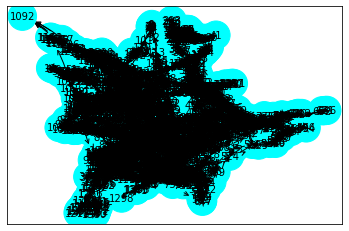

In [27]:
explainer.visualize_subgraph(node_idx=None,edge_index=graph.edge_index,edge_mask=edge_mask,threshold=0.05)

In [26]:
edge_mask.min(),edge_mask.max(),edge_mask.mean(),edge_mask.std()

(tensor(0.2442), tensor(0.7669), tensor(0.2767), tensor(0.0292))